MLJ Demo from the June 2019 MLJ/sktime Sprint

### Load environment and seed RNG

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using Random
Random.seed!(1234);

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


## 1. Basics

### Constructing a task

In [2]:
using MLJ
models()

┌ Info: Recompiling stale cache file /Users/anthony/.julia/compiled/v1.1/MLJ/rAU56.ji for MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1184


Dict{Any,Any} with 9 entries:
  "MultivariateStats" => Any["RidgeRegressor", "PCA"]
  "MLJ"               => Any["MLJ.Constant.DeterministicConstantRegressor", "ML…
  "DecisionTree"      => Any["DecisionTreeRegressor", "DecisionTreeClassifier"]
  "ScikitLearn"       => Any["SVMLRegressor", "SVMNuClassifier", "ElasticNet", …
  "LIBSVM"            => Any["EpsilonSVR", "LinearSVC", "NuSVR", "NuSVC", "SVC"…
  "Clustering"        => Any["KMeans", "KMedoids"]
  "GLM"               => Any["OLSRegressor", "GLMCountRegressor"]
  "NaiveBayes"        => Any["GaussianNBClassifier", "MultinomialNBClassifier"]
  "XGBoost"           => Any["XGBoostCount", "XGBoostRegressor", "XGBoostClassi…

In [3]:
using RDatasets
boston = dataset("MASS", "Boston");
first(boston)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296


In [4]:
scitypes(boston)

(Crim = Continuous,
 Zn = Continuous,
 Indus = Continuous,
 Chas = Count,
 NOx = Continuous,
 Rm = Continuous,
 Age = Continuous,
 Dis = Continuous,
 Rad = Count,
 Tax = Count,
 PTRatio = Continuous,
 Black = Continuous,
 LStat = Continuous,
 MedV = Continuous,)

In [5]:
task = supervised(data=boston,
                  target=:MedV,
                  ignore=:Chas,
                  types=Dict(:Rad=>Continuous,:Tax=>Continuous),
                  is_probabilistic=true)
shuffle!(task)

┌ Info: 
│ is_probabilistic = true
│ input_scitype_union = Continuous 
│ target_scitype_union = Continuous
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/dwOtA/src/tasks.jl:104


SupervisedTask @ 5…24


In [6]:
models(task)

Dict{Any,Any} with 2 entries:
  "MLJ" => Any["ConstantRegressor"]
  "GLM" => Any["OLSRegressor"]

In [7]:
task.is_probabilistic=false
models(task)

Dict{Any,Any} with 6 entries:
  "MultivariateStats" => Any["RidgeRegressor"]
  "MLJ"               => Any["MLJ.Constant.DeterministicConstantRegressor", "KN…
  "DecisionTree"      => Any["DecisionTreeRegressor"]
  "ScikitLearn"       => Any["SVMLRegressor", "ElasticNet", "ElasticNetCV", "SV…
  "LIBSVM"            => Any["EpsilonSVR", "NuSVR"]
  "XGBoost"           => Any["XGBoostRegressor"]

### Binding a task to a model

In [8]:
@load RidgeRegressor
model = RidgeRegressor()

import MLJModels ✔
import MultivariateStats ✔
import MLJModels.MultivariateStats_.RidgeRegressor ✔


RidgeRegressor(lambda = 0.0,) @ 6…20

In [9]:
model.lambda = 0.1

0.1

In [10]:
mach = machine(model, task)

Machine{RidgeRegressor} @ 1…13


### Evaluation

In [11]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measure=rms)
# ### Fitting
train, test = partition(1:nrows(task), 0.7)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.7 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/resampling.jl:92


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  345, 346, 347, 348, 349, 350, 351, 352, 353, 354], [355, 356, 357, 358, 359, 360, 361, 362, 363, 364  …  497, 498, 499, 500, 501, 502, 503, 504, 505, 506])

In [12]:
fit!(mach, rows=train)

┌ Info: Not retraining Machine{RidgeRegressor} @ 1…13.
│  It appears up-to-date. Use force=true to force retraining.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:141


Machine{RidgeRegressor} @ 1…13


In [13]:
fitted_params(mach)
report(mach)

### Predicting on data in the task:

In [14]:
yhat = predict(mach, rows=test);
yhat = predict(mach, task)[test];
yhat = predict(mach, task[test]);
yhat[1:3]

3-element Array{Float64,1}:
 27.875406760269595
 22.539700844045903
 20.687610162632115

In [15]:
y = task[test].y;

In [16]:
rms(yhat, y)

5.189945057488582

### Predicting on "new" data

In [17]:
X = task[test].X;
yhat = predict(mach, X);
yhat[1:4]

4-element Array{Float64,1}:
 27.875406760269595
 22.539700844045903
 20.687610162632115
 16.055185145971578

## 2. Random Forests - Case Study in Ensembling and Tuning

### Quick look at single tree

In [18]:
task = load_iris() # built-in task
shuffle!(task)
@load DecisionTreeClassifier
tree = DecisionTreeClassifier()
mach = machine(tree, task)
evaluate!(mach)

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeClassifier ✔


┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.cross_entropy 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:03


6-element Array{Float64,1}:
 0.1965636053118749 
 0.03278982282299082
 0.19656360531187478
 0.3603373878007589 
 0.360337387800759  
 0.3603373878007589 

In [19]:
yhat = predict(mach, rows=1:3)

3-element Array{UnivariateFinite{CategoricalString{UInt32},Float64},1}:
 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.016129,"setosa"=>0.967742,"versicolor"=>0.016129)
)

 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.967742,"setosa"=>0.016129,"versicolor"=>0.016129)
)

 UnivariateFinite{CategoricalString{UInt32},Float64}(
prob_given_level: Dict("virginica"=>0.016129,"setosa"=>0.016129,"versicolor"=>0.967742)
)


In [20]:
[pdf(d, "virginica") for d in yhat]

3-element Array{Float64,1}:
 0.01612903225806452 
 0.9677419354838711  
 0.016129032258064516

In [21]:
predict_mode(mach, rows=1:3)

3-element Array{CategoricalString{UInt32},1}:
 "setosa"    
 "virginica" 
 "versicolor"

### A random forest

In [22]:
forest = EnsembleModel(atom=tree)

MLJ.ProbabilisticEnsembleModel(atom = DecisionTreeClassifier @ 1…21,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0x000004d2]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 8…16

In [23]:
mach = machine(forest, task)

r = range(forest, :n, lower=10, upper=1000, scale=:log10)

iterator(r,5)

5-element Array{Int64,1}:
   10
   32
  100
  316
 1000

In [24]:
curves = learning_curve!(mach,
                         resampling=Holdout(fraction_train=0.8),
                         nested_range=(n=r,),
                         measure=cross_entropy, n=4,
                         verbosity=0)
using Plots
plot(curves.parameter_values, curves.measurements,
     xlab="number of trees", ylab="rms ")
forest.n = 100; # 750 better

In [25]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity = 1.0,
         max_depth = -1,
         min_samples_leaf = 1,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 0,
         display_depth = 5,
         post_prune = false,
         merge_purity_threshold = 0.9,
         pdf_smoothing = 0.05,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0x000004d2]),
 n = 100,
 parallel = true,
 out_of_bag_measure = Any[],)

In [26]:
r1 = range(tree, :n_subfeatures, lower=1, upper=4);
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);
nested_ranges = (atom=(n_subfeatures=r1,),
                 bagging_fraction=r2)
tuned_forest = TunedModel(model=forest,
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=6),
                          nested_ranges=nested_ranges,
                          measure=cross_entropy)
params(tuned_forest)

(model = (atom = (pruning_purity = 1.0,
                  max_depth = -1,
                  min_samples_leaf = 1,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 0,
                  display_depth = 5,
                  post_prune = false,
                  merge_purity_threshold = 0.9,
                  pdf_smoothing = 0.05,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0x000004d2]),
          n = 100,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 6,
               parallel = true,
               shuffle = false,),
 measure = MLJ.cross_entropy,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 4…29,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 1…12,),
 minimize = true,
 full

In [27]:
mach = machine(tuned_forest, task)

Machine{ProbabilisticTunedModel} @ 9…00


In [28]:
evaluate!(mach, resampling=Holdout(fraction_train=0.7),
          measure=[cross_entropy, misclassification_rate], verbosity=2)
fitted_params(mach)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.7 
│ shuffle=false 
│ measure=Function[cross_entropy, misclassification_rate] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/resampling.jl:92
┌ Info: Training Machine{ProbabilisticTunedModel} @ 9…00.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135
Iterating over a 48-point grid: 100%[=========================] Time: 0:00:08
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/tuning.jl:199


(best_model = ProbabilisticEnsembleModel{DecisionTreeClassifier} @ 1…46,)

In [29]:
best = fitted_params(mach).best_model
@show best.bagging_fraction best.atom.n_subfeatures;

best.bagging_fraction = 0.45454545454545453
(best.atom).n_subfeatures = 4


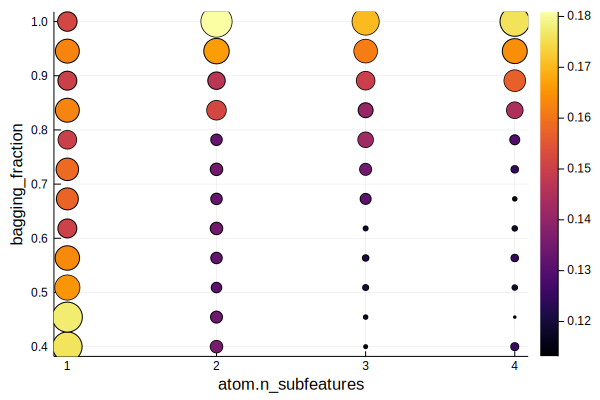

In [30]:
plot(mach)

## 3. Learning Networks

In [31]:
task = load_reduced_ames()

SupervisedTask @ 1…92


In [32]:
X, y = task.X, task.y;
scitypes(X)

(OverallQual = Continuous,
 GrLivArea = Continuous,
 Neighborhood = Multiclass{25},
 x1stFlrSF = Continuous,
 TotalBsmtSF = Continuous,
 BsmtFinSF1 = Continuous,
 LotArea = Continuous,
 GarageCars = Continuous,
 MSSubClass = Multiclass{15},
 GarageArea = Continuous,
 YearRemodAdd = Continuous,
 YearBuilt = Continuous,)

In [33]:
models(task)

Dict{Any,Any} with 1 entry:
  "MLJ" => Any["MLJ.Constant.DeterministicConstantRegressor"]

## Workflow without a pipeline (static data)

In [34]:
hot = OneHotEncoder()
hotM = machine(hot, X)
fit!(hotM)
Xc = transform(hotM, X)

knn = KNNRegressor()
knnM = machine(knn, Xc, y)
fit!(knnM)
yhat= predict(knnM, Xc)

┌ Info: Training Machine{OneHotEncoder} @ 7…39.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135
┌ Info: Spawning 25 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Spawning 15 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Training Machine{KNNRegressor} @ 3…76.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135


1456-element Array{Float64,1}:
 120499.99999999994
 394432.00000000023
 177999.99999999994
 179999.99999999997
 154000.00000000003
 131999.99999999994
 197000.00000000012
 132249.9999999997 
 186700.00000000006
 214000.00000000006
 221500.00000000032
  85500.0          
 177999.99999999994
      ⋮            
 146800.0          
 259999.99999999968
 207000.0000000001 
 177000.00000000038
 139999.9999999999 
 200499.99999999997
 139999.9999999999 
 113000.0          
 179600.0          
 124500.00000000015
 188499.99999999997
 107900.00000000003

## Pipelining (dynamic data)

In [35]:
X = source(X)
y = source(y)

Source @ 1…31

Identical code to build network (`fit!`'s can be dropped)

In [36]:
hot = OneHotEncoder()
hotM = machine(hot, X)
Xc = transform(hotM, X)

knn = KNNRegressor()
knnM = machine(knn, Xc, y)
yhat = predict(knnM, Xc)

Node @ 5…23 = predict(1…53, transform(4…11, 5…51))

Fit the network in one go:

In [37]:
fit!(yhat)

┌ Info: Training NodalMachine{OneHotEncoder} @ 4…11.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135
┌ Info: Spawning 25 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Spawning 15 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Training NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135


Node @ 5…23 = predict(1…53, transform(4…11, 5…51))

In [38]:
hot.drop_last=true

true

In [39]:
fit!(yhat)

┌ Info: Updating NodalMachine{OneHotEncoder} @ 4…11.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:147
┌ Info: Spawning 24 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Spawning 14 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJ.Transformers /Users/anthony/.julia/packages/MLJ/JVPRT/src/builtins/Transformers.jl:445
┌ Info: Training NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:135


Node @ 5…23 = predict(1…53, transform(4…11, 5…51))

In [40]:
knn.K = 7

7

In [41]:
fit!(yhat)

┌ Info: Not retraining NodalMachine{OneHotEncoder} @ 4…11.
│  It appears up-to-date. Use force=true to force retraining.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:141
┌ Info: Updating NodalMachine{KNNRegressor} @ 1…53.
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/machines.jl:147


Node @ 5…23 = predict(1…53, transform(4…11, 5…51))

Instead of `yhat[1:10]` we have

In [42]:
yhat(rows=1:10)

10-element Array{Float64,1}:
 130843.81386332486
 332544.9587051817 
 176265.28435047154
 203767.82439615295
 136978.84622897732
 131724.92769429702
 165692.5091058007 
 168885.5731044217 
 264652.80291212286
 227115.12340804684

Or call on new data:

In [43]:
yhat(task.X)

1456-element Array{Float64,1}:
 130843.81386332486
 332544.9587051817 
 176265.28435047154
 203767.82439615295
 136978.84622897732
 131724.92769429702
 165692.5091058007 
 168885.5731044217 
 264652.80291212286
 227115.12340804684
 227608.92033231404
  96653.56535548567
 156482.38720447902
      ⋮            
 163011.92666397232
 234694.41638974738
 181699.23386663786
 174039.51818329454
 187881.6364677814 
 213099.97613132483
 154150.33752145662
 110888.20670833573
 192930.85515013785
 155675.29688294962
 168567.02190210234
 113090.15018077038

The new data is "plugged into" the orgin node, which must be unique:

In [44]:
origins(yhat) == [X,]

true

## Exporting pipeline as stand-alone model

In [45]:
comp = @from_network SmartKNNRegressor(one_hot_encoding=hot, knn_regressor=knn) <= (X, y, yhat)

SmartKNNRegressor(one_hot_encoding = OneHotEncoder @ 8…13,
                  knn_regressor = KNNRegressor @ 6…96,) @ 7…87

In [46]:
params(comp)
mach = machine(comp, task)
evaluate!(mach, measure=rms)


# # More complicated example

using CategoricalArrays
x1 = rand(6);
x2 = categorical([mod(rand(Int),2) for i in 1:6]);
x3 = rand(6);
y = exp.(x1 -2x3 + 0.1*rand(6))
X = (x1=x1, x2=x2, x3=x3)

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:02


(x1 = [0.630109, 0.343689, 0.615223, 0.445589, 0.480894, 0.189847],
 x2 = CategoricalValue{Int64,UInt32}[0, 0, 1, 0, 0, 1],
 x3 = [0.970981, 0.686989, 0.317158, 0.687898, 0.498569, 0.449293],)

Here's a learning network that: (i) One-hot encodes the input table `X`; (ii)
Log transforms the continuous target `y`; (iii) Fits specified
K-nearest neighbour and ridge regressor models to the data; (iv)
Computes an average of individual model predictions; and (v) Inverse
transforms (exponentiates) the blended predictions.

In [47]:
@load RidgeRegressor

X = source(X)
y = source(y)

hot = machine(OneHotEncoder(), X)

┌ Info: A model named "RidgeRegressor" is already loaded.
│ Nothing new loaded. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/loading.jl:195


NodalMachine @ 1…88 = machine(OneHotEncoder @ 1…21, 1…64)

`W`, `z`, `zhat` and `yhat` are nodes in the network:

In [48]:
W = transform(hot, X) # one-hot encode the input
z = log(y) # transform the target

ridge = RidgeRegressor(lambda=0.1)
knn = KNNRegressor()

ridgeM = machine(ridge, W, z)
knnM = machine(knn, W, z)

NodalMachine @ 1…39 = machine(KNNRegressor @ 3…87, 1…95, 1…93)

Average the predictions of the KNN and ridge models:

In [49]:
zhat = 0.5*predict(ridgeM, W) + 0.5*predict(knnM, W)

Node @ 1…41 = +(#32(predict(1…62, transform(1…88, 1…64))), #32(predict(1…39, transform(1…88, 1…64))))

Inverse the target transformation:

In [50]:
yhat = exp(zhat)

Node @ 6…79 = #30(+(#32(predict(1…62, transform(1…88, 1…64))), #32(predict(1…39, transform(1…88, 1…64)))))

A tree "splat" of the learning network terminating at `yhat`:

In [51]:
MLJ.tree(yhat)

(operation = getfield(MLJ, Symbol("##30#31"))(),
 model = nothing,
 arg1 = (operation = +,
         model = nothing,
         arg1 = (operation = getfield(MLJ, Symbol("##32#33")){Float64}(0.5),
                 model = nothing,
                 arg1 = (operation = StatsBase.predict,
                         model = RidgeRegressor @ 2…18,
                         arg1 = (operation = MLJBase.transform,
                                 model = OneHotEncoder @ 1…21,
                                 arg1 = (source = Source @ 1…64,),
                                 train_arg1 = (source = Source @ 1…64,),),
                         train_arg1 = (operation = MLJBase.transform,
                                       model = OneHotEncoder @ 1…21,
                                       arg1 = (source = Source @ 1…64,),
                                       train_arg1 = (source = Source @ 1…64,),),
                         train_arg2 = (operation = getfield(MLJ, Symbol("##28#29"))(),
           

In [52]:
blend = @from_network Blen(ridge=ridge, knn=knn) <= (X, y, yhat)
blend.ridge.lambda = 0.2
mach = machine(blend, load_reduced_ames())
evaluate!(mach, measure=rms)

┌ Info: Evaluating using cross-validation. 
│ nfolds=6. 
│ shuffle=false 
│ measure=MLJ.rms 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/anthony/.julia/packages/MLJ/JVPRT/src/resampling.jl:137
Cross-validating: 100%[=========================] Time: 0:00:03


6-element Array{Float64,1}:
 23331.522525574146
 27096.40890033297 
 30577.323636229623
 29272.855935539304
 37834.271884729416
 33413.20459176103 

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*